In [2]:
# set cuda visible devices
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

import os
if is_notebook():
    os.environ["CUDA_VISIBLE_DEVICES"] = "" #"1"
    # os.environ['CUDA_LAUNCH_BLOCKING']="1"
    # os.environ['TORCH_USE_CUDA_DSA'] = "1"

import matplotlib 
if not is_notebook():
    matplotlib.use('Agg')

In [3]:
import json
from typing import Optional
from tqdm import tqdm
from collections import defaultdict
from dataclasses import dataclass
from pathlib import Path
from copy import deepcopy
from datetime import datetime

import submitit
import numpy as np
import matplotlib.pyplot as plt


from losses.loss_types import LossType
from utils.utils import conf_to_args


In [ ]:
SCRIPT_NAME = "run_exp.py"

# Experiment Utils

In [4]:
@dataclass
class Experiment:
    seed: int
    loss_type: LossType
    model: str
    mix_rate: float
    mix_rate_lower_bound: float
    dataset: str
    epochs: int
    lr: float
    aux_weight: float = 1.0
    exp_dir: Path = None

    def __post_init__(self):
        self.exp_dir = get_exp_dir(self)

def get_exp_dir(exp: Experiment):
    return Path(f"output/sweep/{exp.dataset}_{exp.loss_type.name}_{exp.model}_{exp.mix_rate}_{exp.mix_rate_lower_bound}_{exp.lr}_{exp.aux_weight}_{exp.epochs}/{exp.seed}")

In [5]:
def get_executor(out_dir: Path):
    executor = submitit.AutoExecutor(folder=out_dir)
    executor.update_parameters(
        timeout_min=60 * 48,
        mem_gb=16,
        gres="gpu:1",
        cpus_per_task=4,
        nodes=1,
        slurm_qos="high",
        slurm_array_parallelism=8
    )
    return executor
def get_executor_local(out_dir: Path):
    executor = submitit.LocalExecutor(folder=out_dir)
    executor.update_parameters(
        timeout_min=60 * 48,
    )
    return executor

def run_experiments(executor, experiments: list[Experiment], script_name: str):
    with executor.batch():
        jobs = []
        for exp in experiments:
            function = submitit.helpers.CommandFunction(
                ["python", script_name] + conf_to_args(exp.__dict__)
            )
            jobs.append(executor.submit(function))
    return jobs

# Run Experiments

In [6]:
seeds = [0, 1, 2]

loss_configs = [ 
    {"loss_type": LossType.DIVDIS},
    {"loss_type": LossType.DIVDIS, "aux_weight": 10.0},
    {"loss_type": LossType.TOPK, "mix_rate_lower_bound": 0.1}, 
    {"loss_type": LossType.TOPK, "mix_rate_lower_bound": 0.5},
    {"loss_type": LossType.TOPK}
]
models = ["Resnet50"]
datasets = ["cifar_mnist", "fmnist_mnist"]
mix_rates = [0.1, 0.25, 0.5, 0.75, 0.9, 1.0]
epochs=10 
lr = 1e-3

experiments: list[Experiment] = []
for seed in seeds:
    for loss_config in loss_configs:
        for model in models:
            for dataset in datasets:
                for mix_rate in mix_rates:
                    if "mix_rate_lower_bound" in loss_config and loss_config["mix_rate_lower_bound"] == mix_rate:
                        continue 
                    loss_config_cp = deepcopy(loss_config)
                    mix_rate_lower_bound = loss_config_cp.pop("mix_rate_lower_bound", mix_rate)
                    exp = Experiment(
                        seed=seed, **loss_config_cp, model=model, mix_rate=mix_rate, 
                        mix_rate_lower_bound=mix_rate_lower_bound, dataset=dataset, 
                        epochs=epochs, lr=lr
                    )
                    experiments.append(exp)


In [6]:
out_dir = Path(f"output_logs/{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}")
out_dir.mkdir(exist_ok=True, parents=True)

executor = get_executor(out_dir)
jobs = run_experiments(executor, experiments, SCRIPT_NAME)


/nas/ucb/oliveradk/miniforge3/envs/od_3_10/lib/python3.10/site-packages/submitit/auto/auto.py:23: UserWarning: Setting 'gres' is deprecated. Use 'slurm_gres' instead.
  warnings.warn(f"Setting '{arg}' is deprecated. Use '{new_arg}' instead.")


In [10]:
print(jobs[0].stderr())
print(jobs[0].stdout())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6048877].

100%|██████████| 31/31 [00:01<00:00, 19.93it/s]

Source train: 100%|██████████| 32/32 [00:18<00:00,  1.75it/s]

Target val: 100%|██████████| 2/2 [00:00<00:00,  6.40it/s]

Source val: 100%|██████████| 8/8 [00:00<00:00, 23.78it/s]

Source train: 100%|██████████| 32/32 [00:17<00:00,  1.79it/s]

Target val: 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]

Source val: 100%|██████████| 8/8 [00:00<00:00, 25.22it/s]

Source train: 100%|██████████| 32/32 [00:17<00:00,  1.79it/s]

Target val: 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]

Source val: 100%|██████████| 8/8 [00:00<00:00, 25.45it/s]

Source train: 100%|██████████| 32/32 [00:17<00:00,  1.79it/s]

Target val: 100%|██████████| 2/2 [00:00<00:00,  6.45it/s]

Source val: 100%|██████████| 8/8 [00:00<00:00, 26.21it/s]

Source train: 100%|██████████| 32/32 [00:17<00:00,  1.78it/s]

Target val: 100%|██

# Process Results

In [7]:
from typing import Literal
def get_exp_metrics(exp: Experiment):
    with open(exp.exp_dir / "metrics.json", "r") as f:
        exp_metrics = json.load(f)
    return exp_metrics

def get_max_acc(
        exp_metrics: dict,
        model_selection: Literal["acc", "loss", "weighted_loss", "repulsion_loss"]="acc"
    ):
    max_accs = np.maximum(np.array(exp_metrics['epoch_acc_0']), np.array(exp_metrics['epoch_acc_1']))
    if model_selection == "acc": 
        max_acc_idx= np.argmax(max_accs)
    elif model_selection == "loss":
        max_acc_idx = np.argmin(exp_metrics["val_loss"])
    elif model_selection == "weighted_loss":
        max_acc_idx = np.argmin(exp_metrics["val_weighted_loss"])
    elif model_selection == "repulsion_loss":
        max_acc_idx = np.argmin(exp_metrics["target_val_weighted_repulsion_loss"])
    else: 
        raise ValueError(f"Invalid model selection: {model_selection}")
    max_acc = max_accs[max_acc_idx]
    return max_acc


# Accuracy Across Mix Rates 

In [8]:
# group by dataset 
# then group by loss config 
def experiments_by_loss_config(experiments: list[Experiment]):
    # divdis aux weight 1 
    divdis_aux_weight_1_experiments = [exp for exp in experiments if exp.loss_type == LossType.DIVDIS and exp.aux_weight == 1.0]
    # divdis aux weight 10 
    divdis_aux_weight_10_experiments = [exp for exp in experiments if exp.loss_type == LossType.DIVDIS and exp.aux_weight == 10.0]
    # topk mix rate lower bound 0.1 
    topk_mix_rate_lower_bound_01_experiments = [exp for exp in experiments if exp.loss_type == LossType.TOPK and exp.mix_rate_lower_bound == 0.1]
    # topk mix rate lower bound 0.5 
    topk_mix_rate_lower_bound_05_experiments = [exp for exp in experiments if exp.loss_type == LossType.TOPK and exp.mix_rate_lower_bound == 0.5]
    # topk 
    topk_experiments = [exp for exp in experiments if exp.loss_type == LossType.TOPK and exp.mix_rate == exp.mix_rate_lower_bound]
    return {
        "DivDis": divdis_aux_weight_1_experiments, 
        "DivDis 10": divdis_aux_weight_10_experiments, 
        "TopK 0.1": topk_mix_rate_lower_bound_01_experiments, 
        "TopK 0.5": topk_mix_rate_lower_bound_05_experiments, 
        "TopK": topk_experiments
    }


In [9]:
# data structure: dictionary with keys method types, values dict[mix_rate, list[len(seeds)]] of cifar accuracies (for now ignore case where mix_rate != mix_rate_lower_bound)
def get_acc_results(
    experiments: list[Experiment], 
    model_selection: Literal["acc", "loss", "weighted_loss", "repulsion_loss"]="acc",
):
    results = defaultdict(list)
    for exp in experiments:
        exp_metrics = get_exp_metrics(exp)
        max_acc = get_max_acc(exp_metrics, model_selection)
        results[exp.mix_rate].append(max_acc)
    results = dict(results)
    return results


In [10]:
cifar_experiments = [exp for exp in experiments if exp.dataset == "cifar_mnist"]
fmnist_experiments = [exp for exp in experiments if exp.dataset == "fmnist_mnist"]

cifar_exp_by_loss_config = experiments_by_loss_config(cifar_experiments)
fmnist_exp_by_loss_config = experiments_by_loss_config(fmnist_experiments)


In [11]:
cifar_results = {k: get_acc_results(v, model_selection="loss") for k, v in cifar_exp_by_loss_config.items()}
fmnist_results = {k: get_acc_results(v, model_selection="loss") for k, v in fmnist_exp_by_loss_config.items()}


In [12]:
def plot_acc_results(results: dict, ylim: tuple[float, float]=(0.5, 1.0), title: Optional[str]=None):
    # plot mean accuracy with dotted standard deviation for each method type at each mix rate
    for loss_type, loss_results in results.items():
        mix_rates = sorted(loss_results.keys())
        means = [np.mean(loss_results[mix_rate]) for mix_rate in mix_rates]
        stds = [np.std(loss_results[mix_rate]) for mix_rate in mix_rates]
        if isinstance(loss_type, LossType):
            loss_type = loss_type.name 
        plt.plot(mix_rates, means, label=loss_type, marker='o')
        plt.fill_between(mix_rates, 
                        [m - s for m, s in zip(means, stds)],
                        [m + s for m, s in zip(means, stds)],
                        alpha=0.2)

    plt.xlabel('Mix Rate')
    plt.ylabel('Accuracy')
    if title is not None:
        plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    # start y axis at 0.75
    plt.ylim(*ylim)
    plt.show()

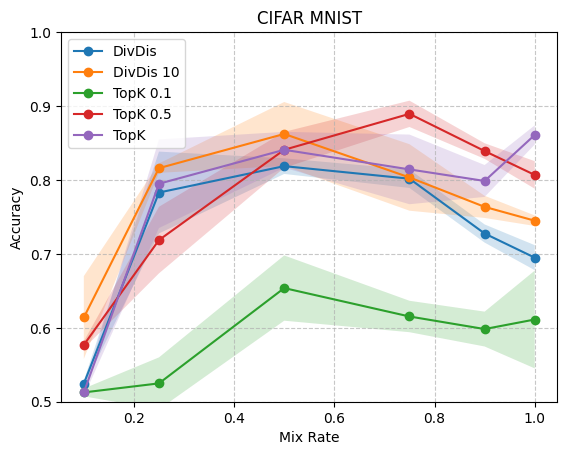

In [13]:
plot_acc_results(cifar_results, title="CIFAR MNIST")

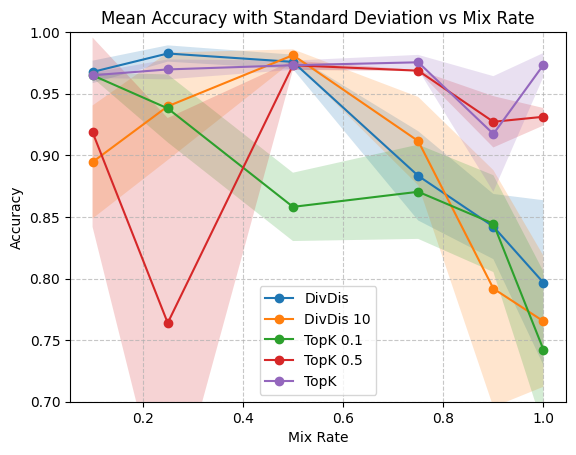

In [47]:
plot_acc_results(fmnist_results, ylim=(0.7, 1.0))


## Aggregate Validation Loss Selection

In [13]:
model_selection = "min_val_loss"
results_val_loss = get_acc_results(experiments, model_selection=model_selection)

In [ ]:
plot_acc_results(results_val_loss)

In [ ]:
# compute average difference between oracle and validation loss across mix rates and runs 
def plot_model_selection_diffs(results, results_model_selection, model_selection_name: str):
    model_selection_diffs = defaultdict(list)
    # iterate over each loss type and results 
    for loss_type in losses: 
        for mix_rate in mix_rates:
            oracle_acc = results[loss_type][mix_rate]
            model_select_acc = results_model_selection[loss_type][mix_rate]
            diffs = (np.array(oracle_acc) - np.array(model_select_acc)).tolist()
            model_selection_diffs[loss_type].extend(diffs)

    # plot diff means and standad deviations as bar chart 
    model_selecttion_diffs_means = {loss_type.name: np.mean(diffs) for loss_type, diffs in model_selection_diffs.items()}
    model_selecttion_diffs_stds = {loss_type.name: np.std(diffs) for loss_type, diffs in model_selection_diffs.items()}
    plt.bar(model_selecttion_diffs_means.keys(), model_selecttion_diffs_means.values())
    plt.errorbar(model_selecttion_diffs_means.keys(), model_selecttion_diffs_means.values(), 
                 yerr=model_selecttion_diffs_stds.values(), fmt='o', capsize=5, ecolor='lightblue')
    plt.xlabel('Loss Type')
    plt.ylabel('Average Difference')
    plt.title(f'Average Difference between Oracle and {model_selection_name}')
    plt.show()

plot_model_selection_diffs(results, results_val_loss, "Total Validation Loss")


## Repulsion Loss Selection 

In [ ]:
model_selection = "min_repulsion_loss"
results_repulsion_loss = get_acc_results(experiments, model_selection=model_selection)
plot_acc_results(results_repulsion_loss)

In [ ]:
plot_model_selection_diffs(results, results_repulsion_loss, "Diversity Loss")

# Accuracy over Epochs

In [91]:
# data structure: dictionary with keys method types, values dict[mix_rate, list[len(seeds)]] of cifar accuracies (for now ignore case where mix_rate != mix_rate_lower_bound)
def get_acc_results_over_epochs(
    experiments: list[Experiment], 
    lower_bound: Optional[float]=None
):
    results = defaultdict(lambda: defaultdict(list))
    for exp in experiments:
        if lower_bound is not None and exp.mix_rate_lower_bound != lower_bound:
            continue
        elif lower_bound is None:
            if exp.mix_rate != exp.mix_rate_lower_bound:
                continue
        exp_metrics = get_exp_metrics(exp)
        # take max over epoch_acc_0, epoch_acc_1
        max_acc = np.maximum(np.array(exp_metrics['epoch_acc_0']), np.array(exp_metrics['epoch_acc_1']))
        results[exp.loss_type][exp.mix_rate].append(max_acc)
    results = {k: dict(v) for k, v in results.items()}
    return results

results_acc_over_epochs = get_acc_results_over_epochs(experiments)

In [ ]:
mix_rate = 0.5 

for loss_type, loss_type_acc_over_epochs in results_acc_over_epochs.items():
    # compute mean and std over seeds
    mean_acc_over_epochs = np.mean(loss_type_acc_over_epochs[mix_rate], axis=0)
    std_acc_over_epochs = np.std(loss_type_acc_over_epochs[mix_rate], axis=0)
    plt.plot(mean_acc_over_epochs, label=f"{loss_type.name}")
    plt.fill_between(range(len(mean_acc_over_epochs)), 
                     mean_acc_over_epochs - std_acc_over_epochs,
                     mean_acc_over_epochs + std_acc_over_epochs,
                     alpha=0.2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()